In [64]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st104702/


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-1-c49d9e301980>:24 

In [56]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


In [3]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.show()

+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|                msno|             song_id|source_system_tab| source_screen_name|        source_type|target|
+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|FGtllVqz18RPiwJj/...|BBzumQNXUHKdEBOB7...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4...|bhp/MpSNoqoxOIB+/...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|JNWfrrC7zNN7BdMps...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|2A87tzfnJTSWqD7gI...|       my library|Local playlist more|     local-playlist|     1|
|FGtllVqz18RPiwJj/...|3qm6XTZ6MOCU11x8F...|          explore|            Explore|    online-playlist|     1|
|FGtllVqz18RPiwJj/...|3Hg5kugV1S0wzEVLA...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4.

# Explanation 1

Here, I first joined the 2 tables via the .join function. The key being "song_id".

Then I used the .groupBy function to get a list based on the "artist_name". 
F.count allows me to count the total number of listens per "artist_name" and F.countDistinct allows me to sort out the duplicate listens to get the "unique user listens"

In the first dataframe, .orderBy(F.col("raw listens").desc()) gives me a sorted descending list of raw listens

In the second dataframe .orderBy(F.col("unique user listens").desc()) gives me a sorted descending list of unique user listens

In [57]:
joined = listen_history.join(songs, ["song_id"], 'inner')

joined.groupBy("artist_name")\
.agg(F.count(F.col("msno")).alias("raw listens"), F.countDistinct(F.col("msno")).alias("unique user listens"))\
.orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(22)

,artist_name,raw listens,unique user listens
0,Various Artists,303617,22256
1,周杰倫 (Jay Chou),186776,18727
2,五月天 (Mayday),182088,18183
3,林俊傑 (JJ Lin),115325,17160
4,田馥甄 (Hebe),104946,18771
5,aMEI (張惠妹),82799,15169
6,陳奕迅 (Eason Chan),76035,16290
7,玖壹壹,70445,12487
8,G.E.M.鄧紫棋,67297,16064
9,BIGBANG,61927,10366


In [29]:
joined1 = listen_history.join(songs, ["song_id"], 'inner')

joined1.groupBy("artist_name")\
.agg(F.count(F.col("msno")).alias("raw listens"), F.countDistinct(F.col("msno")).alias("unique user listens"))\
.orderBy(F.col("unique user listens").desc())\
.limit(100).toPandas().head(22)

,artist_name,raw listens,unique user listens
0,Various Artists,303617,22256
1,田馥甄 (Hebe),104946,18771
2,周杰倫 (Jay Chou),186776,18727
3,五月天 (Mayday),182088,18183
4,林俊傑 (JJ Lin),115325,17160
5,陳奕迅 (Eason Chan),76035,16290
6,G.E.M.鄧紫棋,67297,16064
7,Eric 周興哲,49426,15672
8,謝和弦 (R-chord),57040,15313
9,aMEI (張惠妹),82799,15169


# Explanation 2
Here, I first joined the 2 tables via the .join function. The key being "song_id".

Then I used the .groupBy function to get a list based on the "language". 
F.count allows me to count the total number of listens per "raw listens".

"orderBy(F.col("raw listens").desc())" gives me a sorted descending list of raw listens


In [62]:
joined2 = listen_history.join(songs, ["song_id"], 'inner')

joined2.groupBy("language")\
.agg(F.count(F.col("msno")).alias("raw listens"))\
.orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(3)

,language,raw listens
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


# Explanation 3

Here, I first joined the 2 tables via the .join function. The key being "song_id".

Then I used the .groupBy function to get a list based on the "language". 

f.avg allows me to obtain the average length of listening by language

I print to get a view of my dataframe.

Then I use the .hist function from pandas to get a histogram based on the 'song_length_by_language' column


Same process for song_length_by_genre.

In [122]:
joined3 = listen_history.join(songs, ["song_id"], 'inner')

query = joined3.groupBy("language")\
.agg(F.avg(F.col("song_length")).alias("song_length_by_language"))\
.orderBy(F.col("song_length_by_language").desc())\
.limit(100).toPandas().head(20)

print(query)

   language  song_length_by_language
0         3            271839.555556
1      -1.0            263936.036473
2      10.0            261962.855338
3        17            257836.400000
4      17.0            257025.518761
5       3.0            255362.383087
6        52            253014.781250
7      24.0            248723.906921
8      45.0            243895.783062
9        24            241812.000000
10     52.0            225715.582079
11     31.0            219288.582905
12     38.0            217447.528571
13     59.0            204931.222991
14       -1            190871.062500
15     None            180162.675676


array([[<AxesSubplot:title={'center':'song_length_by_language'}>]],
      dtype=object)

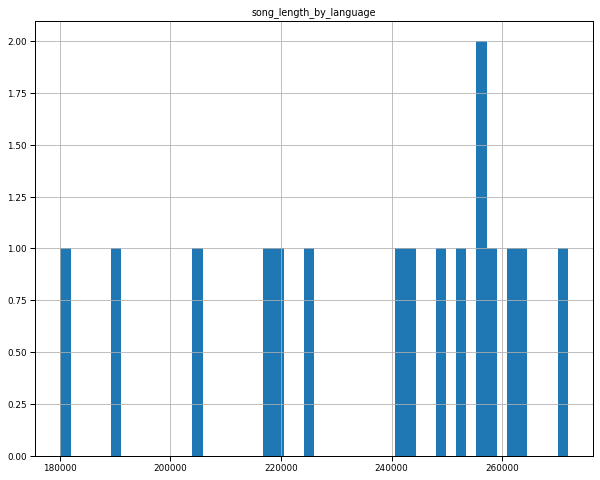

In [121]:
query.hist(column='song_length_by_language',bins=50,figsize=(10, 8),layout=(1,1))

In [120]:
joined3 = listen_history.join(songs, ["song_id"], 'inner')

query2 = joined3.groupBy("genre_ids")\
.agg(F.avg(F.col("song_length")).alias("song_length_by_genre"))\
.orderBy(F.col("song_length_by_genre").desc())\
.limit(100).toPandas().head(20)

print(query2)

         genre_ids  song_length_by_genre
0    1609|275|1572          3.172937e+06
1         1096|958          2.849880e+06
2     1152|873|947          9.193892e+05
3         1152|873          8.537690e+05
4              516          7.886561e+05
5          242|691          7.108440e+05
6              184          7.071537e+05
7   1969|2100|2022          6.104288e+05
8              474          6.043074e+05
9    275|1955|1572          5.888000e+05
10         545|726          5.794955e+05
11             502          5.257004e+05
12             873          5.228866e+05
13         444|786          4.815930e+05
14            1000          4.733462e+05
15        1609|786          4.632670e+05
16    1152|947|958          4.530249e+05
17             545          4.523122e+05
18        940|1609          4.321868e+05
19            1033          4.179340e+05


array([[<AxesSubplot:title={'center':'song_length_by_genre'}>]],
      dtype=object)

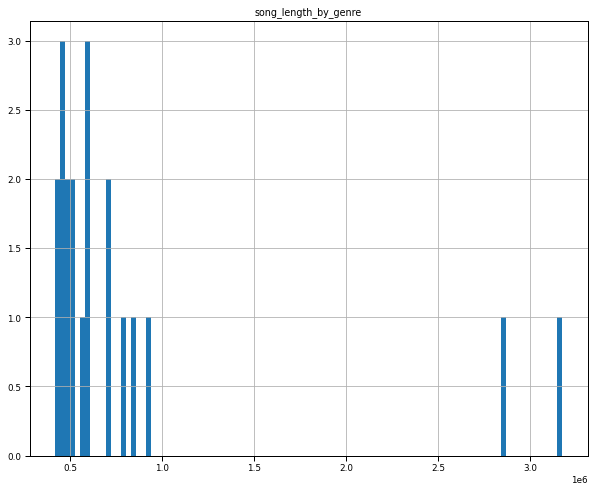

In [119]:
query2.hist(column='song_length_by_genre',bins=100,figsize=(10, 8),layout=(1,1))

# What is the longest genre? What is more valuable in terms of length: language or genre?

The longest genre is the genre with the code "1609|275|1572". 

Genre seems to be more valuable than language to analyse length.
